In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
sys.path.append('../../../tool_code/python_tool_code/frequency_dataset_generation/')

from DataPlot import Data_Load_Plot
from Scaling import time_scaling, time_inv_scaling
from FFT_func import FFT
from Welch_func import Welch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


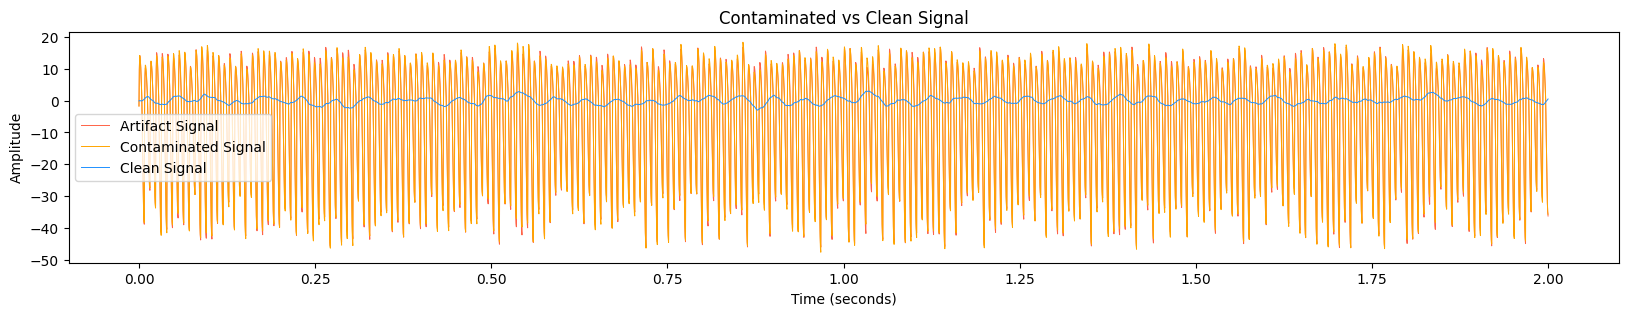

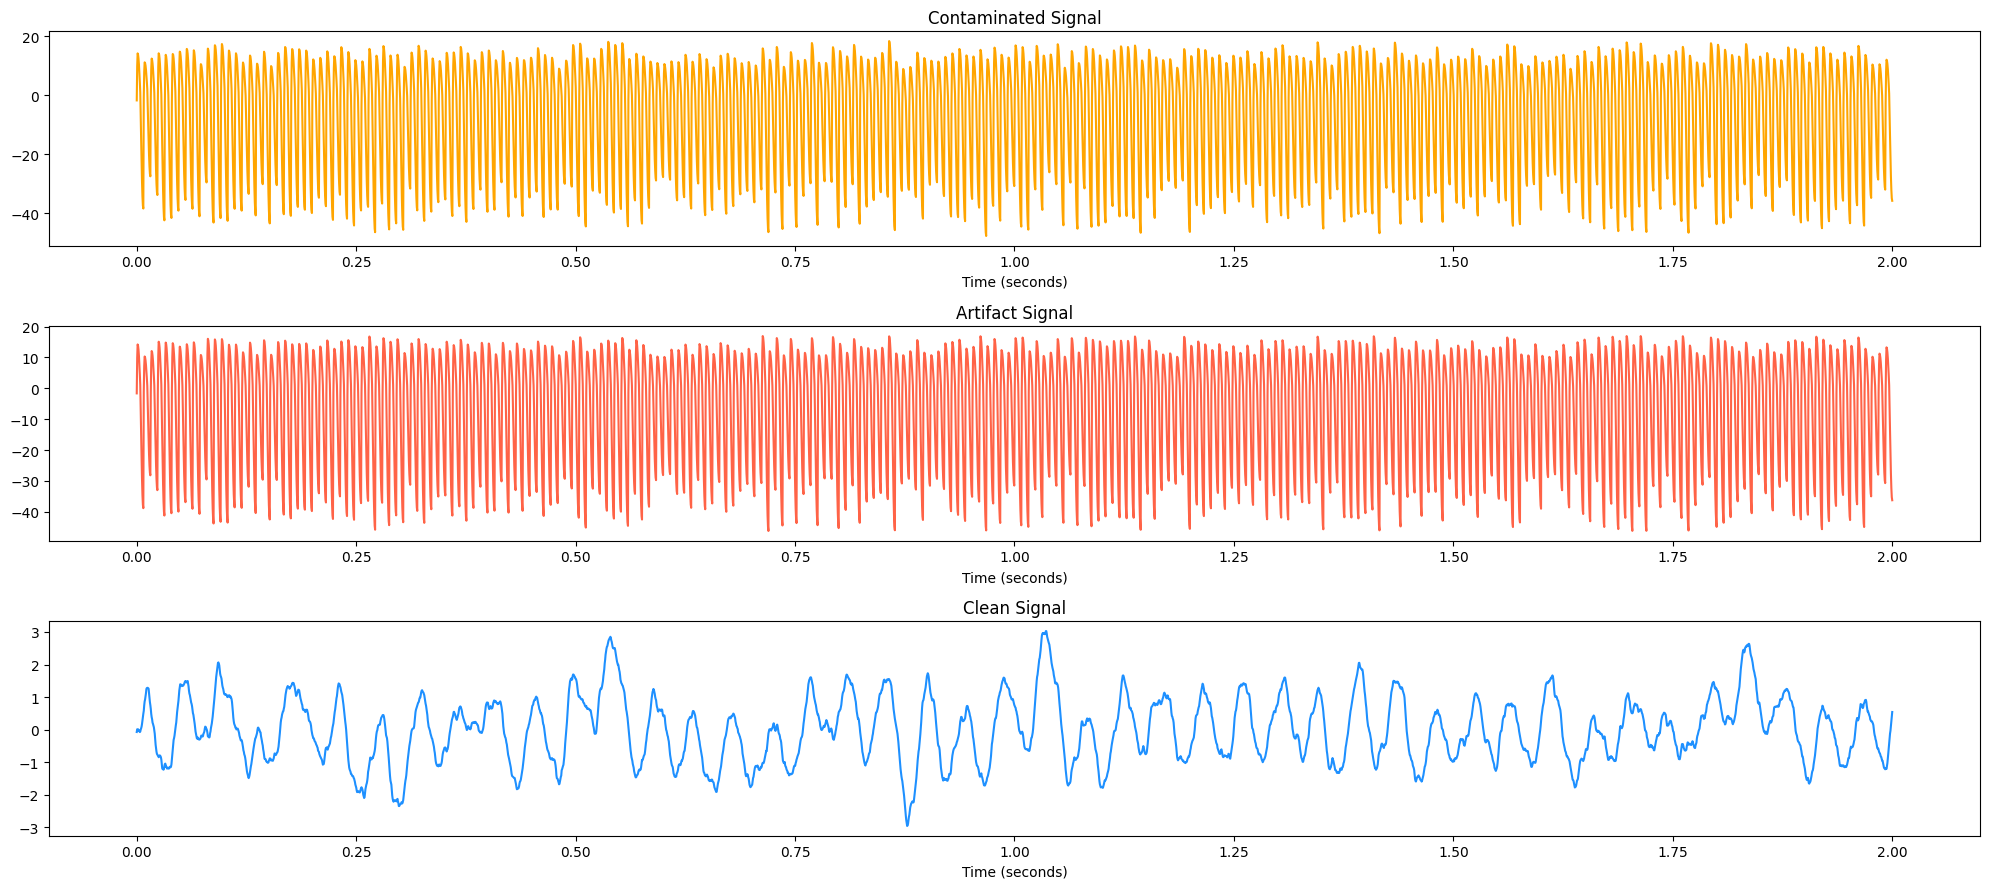

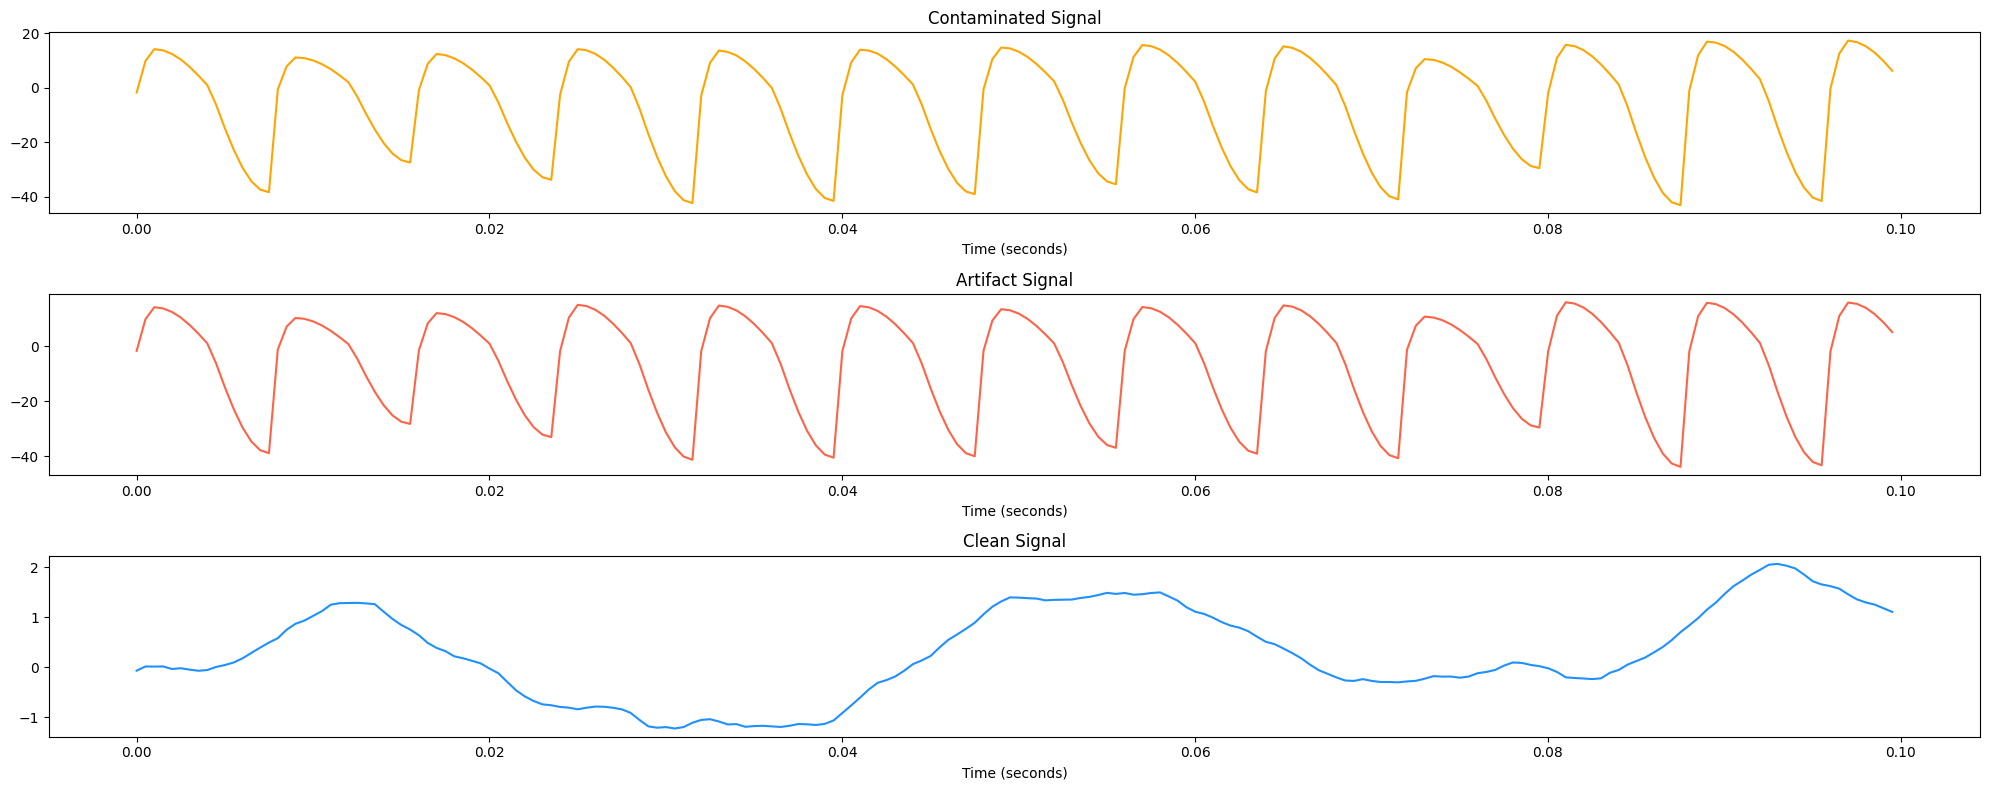

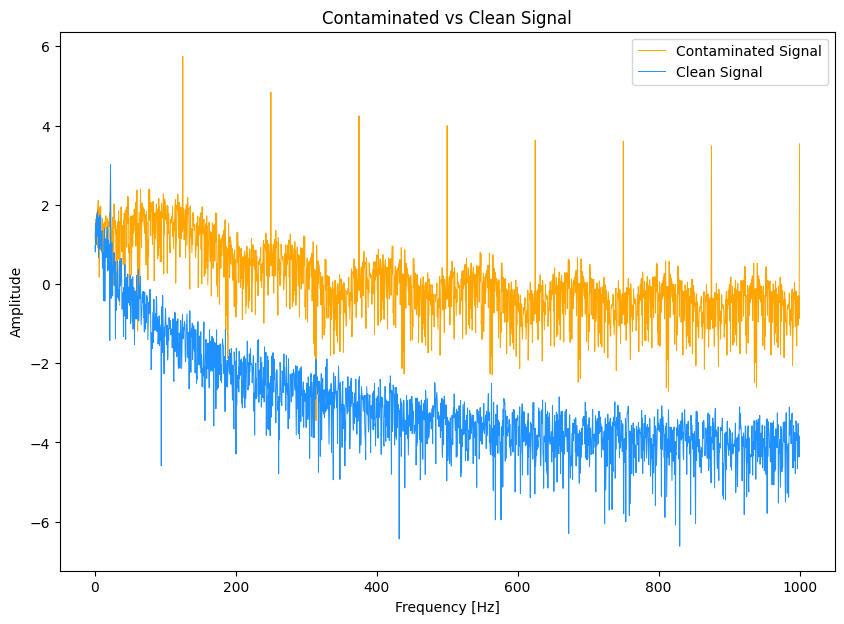

In [10]:
# 데이터 load & plot
fpath='../../../data/synthetic_data/'

Contaminated, Clean, Artifact = Data_Load_Plot(fpath)

In [11]:
fs = 2000
num_signals = 1000
n_seconds = 2

fft_win_time = 0.5  # 윈도우 길이 (초)
n_fft = int(fft_win_time * fs)  # 1000 샘플
fft_overlap_time = int(fft_win_time / 2 * fs)  # 오버랩 크기, 500 샘플, 50%
freqs = torch.fft.rfftfreq(n_fft, 1 / fs) # 주파수 대역

In [12]:
# stft
x_stft = []
x_stft_2 =[]
def compute_stft(data, fs, fft_win_time):
    n_fft = int(fft_win_time * fs)
    fft_overlap_time = int(fft_win_time / 2 * fs)
    
    stft_results = []
    for sample in data:
        # torch.tensor로 변환할 때 dtype=torch.float32로 명시적으로 지정
        sample_tensor = torch.tensor(sample, dtype=torch.float32)
        Zxx = torch.stft(sample_tensor, n_fft, hop_length=n_fft - fft_overlap_time, return_complex=True)
        stft_results.append(Zxx)

    # 넘파이 배열로 변환
    stft_results_np = np.array(stft_results)
    
    return stft_results_np

x_stft = compute_stft(Contaminated, fs, fft_win_time)
y_stft = compute_stft(Clean, fs, fft_win_time)

# print(f"x_data shape: {x_data.shape}") # (1000, 4000)
print(f"x_stft shape: {x_stft.shape}") # (1000, 501, 9)
# print(f"x_stft_2 shape: {x_stft_2.shape}") # (1000, 501, 9, 2)
# print(f"y_data shape: {y_data.shape}") # (1000, 4000)
print(f"y_stft shape: {y_stft.shape}") # (1000, 501, 9)

print(f"x_stft: {x_stft[0][0]}")
print(f"y_stft: {y_stft[0][0][0]}")

# 각 요소는 (frequency_bins, time_frames, 2)의 복소수(2; 실수, 허수 성분) 텐서입니다.
# x_data shape: (4000,)
# x_stft shape: (1000, 501, 9)

c:\Users\User\anaconda3\envs\torch2\lib\site-packages\torch\functional.py:665: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\SpectralOps.cpp:842.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


x_stft shape: (1000, 501, 9)
y_stft shape: (1000, 501, 9)
x_stft: [-6620.116 +0.j -6803.12  +0.j -6831.889 +0.j -6746.3867+0.j
 -6683.508 +0.j -6541.9863+0.j -6609.205 +0.j -6732.0815+0.j
 -6751.717 +0.j]
y_stft: (98.07908630371094+0j)


In [13]:
nperseg = 1000  # STFT 윈도우 길이
noverlap = 500  # STFT 윈도우 오버랩

# 주파수 벡터 계산
freq_bins = x_stft.shape[1]  # 주파수 bin의 수
fft_freqs = np.fft.rfftfreq(nperseg, 1/fs)

# 시간 벡터 계산
time_bins = x_stft.shape[2]  # 시간 bin의 수
time_vector = np.arange(0, time_bins) * (nperseg - noverlap) / fs

# log10 씌워주기
x_stft= np.log10(np.abs(x_stft)**2 + 1e-6)
y_stft = np.log10(np.abs(y_stft)**2 + 1e-6)

# x_stft = np.log10(np.abs(x_stft) + 1e-6)
# y_stft = np.log10(np.abs(y_stft) + 1e-6)

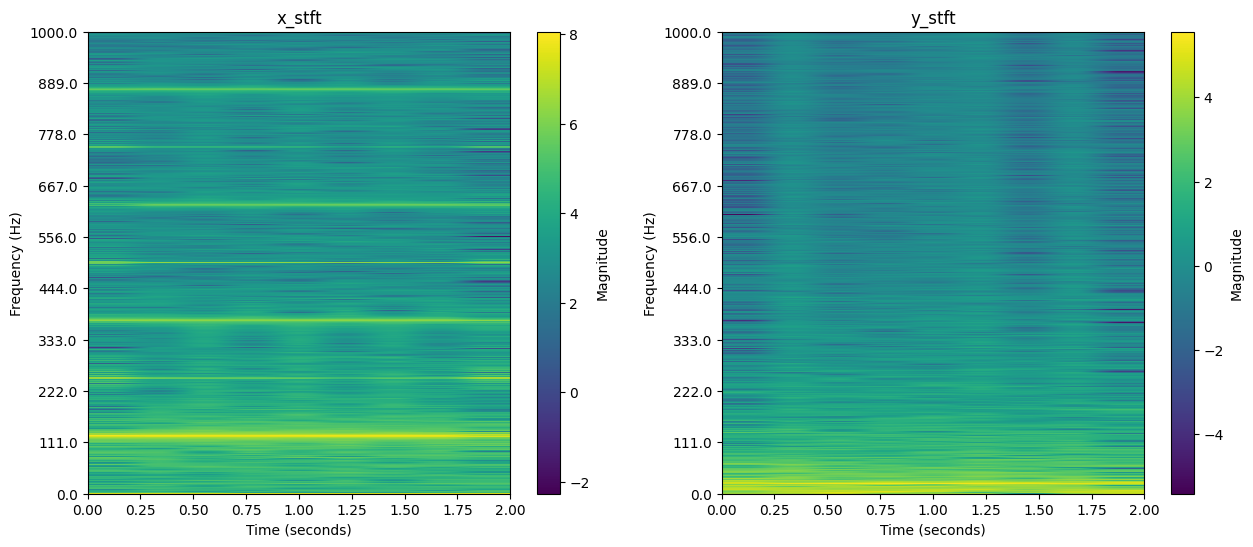

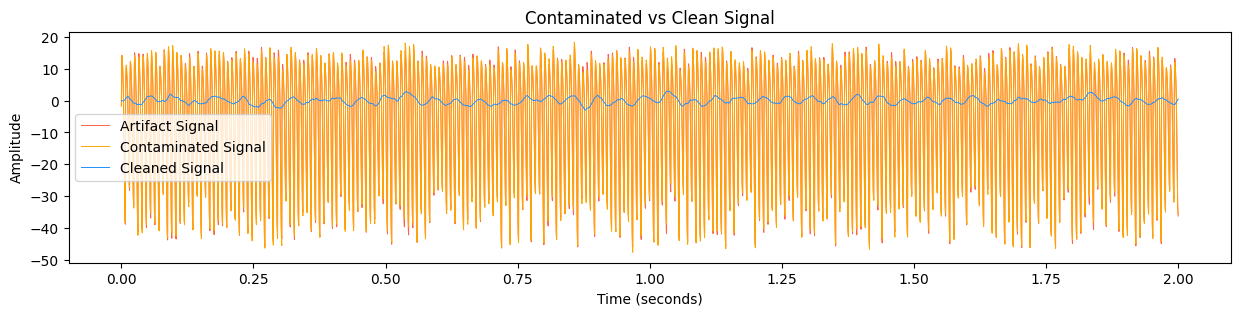

<Figure size 640x480 with 0 Axes>

In [16]:
t = np.linspace(0, 2, num=4000) 
# 2D spectrogram
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(x_stft[0, :, :], aspect='auto', origin='lower', cmap='viridis', extent=[time_vector[0], time_vector[-1], fft_freqs[0], fft_freqs[-1]])
plt.colorbar(label='Magnitude')
plt.title('x_stft')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.yticks(np.linspace(fft_freqs[0], fft_freqs[-1], num=10), np.round(np.linspace(fft_freqs[0], fft_freqs[-1], num=10)))

plt.subplot(1, 2, 2)
plt.imshow(y_stft[0, :, :], aspect='auto', origin='lower', cmap='viridis', extent=[time_vector[0], time_vector[-1], fft_freqs[0], fft_freqs[-1]])
plt.colorbar(label='Magnitude')
plt.title('y_stft')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.yticks(np.linspace(fft_freqs[0], fft_freqs[-1], num=10), np.round(np.linspace(fft_freqs[0], fft_freqs[-1], num=10)))

plt.figure(figsize=(15, 3))
plt.plot(t, Artifact[0], label='Artifact Signal', color='tomato', alpha=1, linewidth=0.7)
plt.plot(t, Contaminated[0], label='Contaminated Signal', color='orange', alpha=1, linewidth=0.7)
plt.plot(t, Clean[0], label='Cleaned Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)');plt.ylabel('Amplitude');plt.title('Contaminated vs Clean Signal');plt.legend();plt.show()

plt.tight_layout()
plt.show()


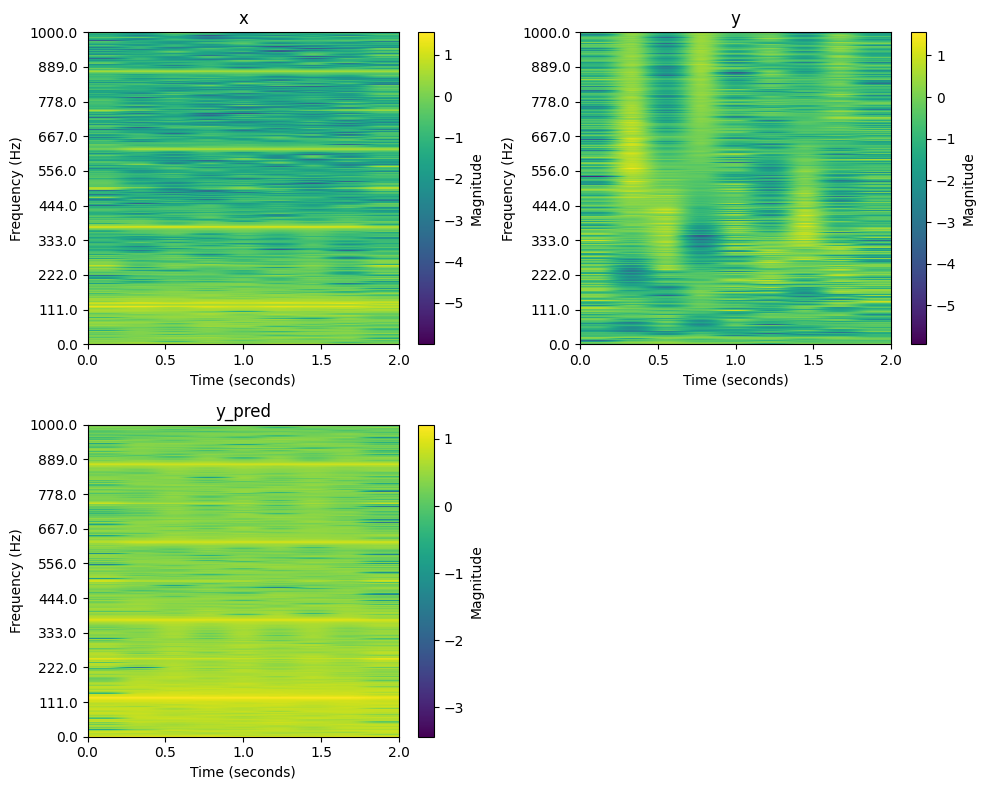

In [33]:
# 2D spectrogram
vmin = min(Contaminated.min(), Clean.min(), SACed.min())
vmax = max(Contaminated.max(), Clean.max(), SACed.max())

Contaminated= np.log10(np.abs(Contaminated)**2 + 1e-6)
Clean = np.log10(np.abs(Clean)**2 + 1e-6)
SACed = np.log10(np.abs(SACed)**2 + 1e-6)

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
# plt.imshow(Contaminated[0, :, :], aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
plt.imshow(Contaminated[0, :, :], aspect='auto', origin='lower', cmap='viridis', extent=[time_vector[0], time_vector[-1], fft_freqs[0], fft_freqs[-1]])
plt.colorbar(label='Magnitude')
plt.title('x')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.yticks(np.linspace(fft_freqs[0], fft_freqs[-1], num=10), np.round(np.linspace(fft_freqs[0], fft_freqs[-1], num=10)))

plt.subplot(2, 2, 2)
# plt.imshow(Clean[0, :, :], aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
plt.imshow(Clean[0, :, :], aspect='auto', origin='lower', cmap='viridis', extent=[time_vector[0], time_vector[-1], fft_freqs[0], fft_freqs[-1]])
plt.colorbar(label='Magnitude')
plt.title('y')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.yticks(np.linspace(fft_freqs[0], fft_freqs[-1], num=10), np.round(np.linspace(fft_freqs[0], fft_freqs[-1], num=10)))

plt.subplot(2, 2, 3)
# plt.imshow(SACed[0, :, :], aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
plt.imshow(x_stft[0, :, :], aspect='auto', origin='lower', cmap='viridis', extent=[time_vector[0], time_vector[-1], fft_freqs[0], fft_freqs[-1]])
plt.colorbar(label='Magnitude')
plt.title('y_pred')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.yticks(np.linspace(fft_freqs[0], fft_freqs[-1], num=10), np.round(np.linspace(fft_freqs[0], fft_freqs[-1], num=10)))

plt.tight_layout()
plt.show()

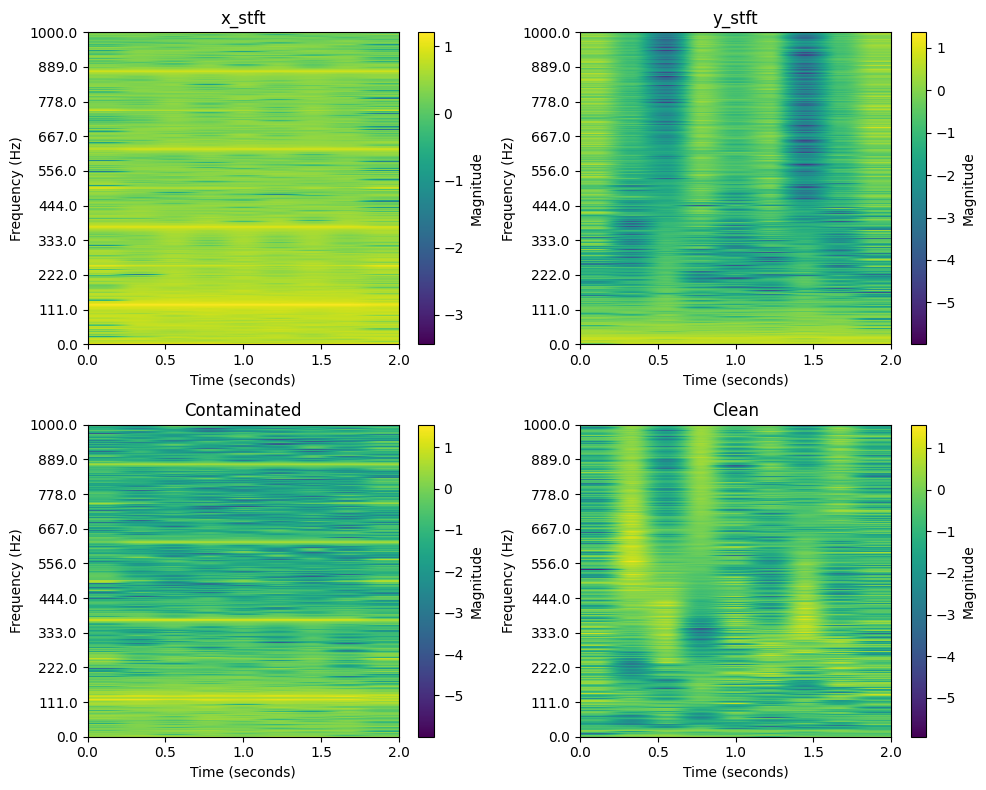

In [35]:
# 2D spectrogram - check
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.imshow(x_stft[0, :, :], aspect='auto', origin='lower', cmap='viridis', extent=[time_vector[0], time_vector[-1], fft_freqs[0], fft_freqs[-1]])
plt.colorbar(label='Magnitude')
plt.title('x_stft')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.yticks(np.linspace(fft_freqs[0], fft_freqs[-1], num=10), np.round(np.linspace(fft_freqs[0], fft_freqs[-1], num=10)))

plt.subplot(2, 2, 2)
plt.imshow(y_stft[0, :, :], aspect='auto', origin='lower', cmap='viridis', extent=[time_vector[0], time_vector[-1], fft_freqs[0], fft_freqs[-1]])
plt.colorbar(label='Magnitude')
plt.title('y_stft')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.yticks(np.linspace(fft_freqs[0], fft_freqs[-1], num=10), np.round(np.linspace(fft_freqs[0], fft_freqs[-1], num=10)))

plt.subplot(2, 2, 3)
# plt.imshow(Contaminated[0, :, :], aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
plt.imshow(Contaminated[0, :, :], aspect='auto', origin='lower', cmap='viridis', extent=[time_vector[0], time_vector[-1], fft_freqs[0], fft_freqs[-1]])
plt.colorbar(label='Magnitude')
plt.title('Contaminated')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.yticks(np.linspace(fft_freqs[0], fft_freqs[-1], num=10), np.round(np.linspace(fft_freqs[0], fft_freqs[-1], num=10)))

plt.subplot(2, 2, 4)
# plt.imshow(Clean[0, :, :], aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
plt.imshow(Clean[0, :, :], aspect='auto', origin='lower', cmap='viridis', extent=[time_vector[0], time_vector[-1], fft_freqs[0], fft_freqs[-1]])
plt.colorbar(label='Magnitude')
plt.title('Clean')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.yticks(np.linspace(fft_freqs[0], fft_freqs[-1], num=10), np.round(np.linspace(fft_freqs[0], fft_freqs[-1], num=10)))

plt.tight_layout()
plt.show()